<h1 style='text-align:center'>3D+Texture Garment Reconstruction Challenge</h1>
<h2 style='text-align:center'>Starter Kit: Demo</h2>

Through this document you'll learn how <a href=https://chalearnlap.cvc.uab.cat/dataset/38/description/>CLOTH3D</a> dataset is structured and how to read data from it. This dataset contains 3D and RGB data, plus additional metadata. Due to the large scale of the dataset and in order to make it accessible worldwide, most of it is efficiently compressed.

We provide with a set of tools to extract and/or read this data. The code includes explanations of the different functions as comments.

<h2>Setups</h2>

The code requires deodr toolbox to render depth images.

Put the PR7 zip file in your google drive under 'cloth3d' folder.

In [10]:
# !pip3 install deodr
# 
# from google.colab import drive
# drive.mount('/gdrive')
# 
# %cd '/gdrive/MyDrive/cloth3d'

<h2>DataReader</h2>

This is the main class for I/O operations. Found at 'StarterKit/DataReader/read.py'.<br>
NOTE: students shall change path to data if necessary (line 15).

In [1]:
import sys
sys.path.append('./cloth3d/DataReader')

In [2]:
from read import DataReader

reader = DataReader()

<h2>Metadata</h2>

First of all, we will show how to load the associated metadata of each sample and explain its structure and meaning.

<h6>Dependencies</h6>
<ul>
    <li>scipy</li>
</ul>

In [3]:
import os
from random import choice

samples = os.listdir('./cloth3d/Samples')
sample = '03543'#choice(samples) # sample/sequence name
frame = 9 # frame to visualize
print(sample)
print('----------------')

info = reader.read_info(sample)

# Display utility
from pprint import PrettyPrinter
printer = PrettyPrinter(indent=4)
printer.pprint(info)

03543
----------------
{   'camLoc': array([5.11803302, 0.        , 1.        ]),
    'gender': 0,
    'lights': {   'data': [   {   'loc': array([-0.16296396,  0.17890805,  3.        ]),
                                  'pwr': 60.63535102913448},
                              {   'loc': array([-0.80911929,  1.76111837,  3.        ]),
                                  'pwr': 86.73653150161476}],
                  'type': 'point'},
    'outfit': {'Dress': {'fabric': 'silk', 'texture': {'type': 'pattern'}}},
    'poses': array([[ 1.22245617,  1.22343086,  1.22420005, ...,  1.24420474,
         1.24499912,  1.24512479],
       [ 1.20860963,  1.2093374 ,  1.21035417, ...,  1.22403724,
         1.22320321,  1.22119159],
       [ 1.17170214,  1.17116668,  1.17039063, ...,  1.17550156,
         1.17503969,  1.174383  ],
       ...,
       [-0.21548521, -0.21484853, -0.20559238, ..., -0.1137761 ,
        -0.11301572, -0.11589138],
       [ 0.13436331,  0.13420635,  0.13412445, ...,  0.1671725

<h3>Human metadata</h3>

Subjects are based on SMPL. This metadata has been used for the generation of the 3D human models.
<ul>
    <li><b>pose:</b> SMPL pose parameters for each frame of the sequence. $\mathbb{R}^{72\times N.frames}$ </li>
    <li><b>shape:</b> SMPL shape parameters. $\mathbb{R}^{10}$</li>
    <li><b>gender:</b> subject's gender. $0$: female, $1$: male.</li>
    <li><b>trans:</b> SMPL root joint location. $\mathbb{R}^{3\times N.frames}$. Root joint is first aligned at $(0,0,0)$ and later moved to its corresponding location. NOTE: SMPL does not align root joint at origin by default.</li>
</ul>

<h3>Garment metadata</h3>

Before explaining the metadata, it is important to know that garments are categorized in six main types: Tshirt, Top, Trousers, Skirt, Jumpsuit and Dress.<br>
Also, there are four different garment fabrics: Cotton, Silk, Denim and Leather.

<ul>
    <li><b>outfit:</b> description of the subject's garment(s).</li>
    <li><b>tightness:</b> two-dimensional array that describes garment tightness. For details, we refer to <a href="https://arxiv.org/abs/1912.02792">CLOTH3D</a> paper, Sec.3.2.</li>
</ul>

Outfit description consists of a dictionary where each key is the garment type and its value contains garment metadata structured as follows:
<ul>
    <li><b>fabric:</b> type of fabric used for the given garment. This has an impact in cloth simulation and rendering.</li>
    <li>
        <b>texture:</b>
        <ul>
            <li><b>type:</b> 'color' or 'pattern'. Plain RGB color or a color pattern. In case of a color pattern, the sample folder will contain a PNG file named as '[GARMENT TYPE].png'</li>
            <li><b>data:</b> RGB color. Only if texture type is 'color'.
        </ul>
    </li>
</ul>

<h3>World metadata</h3>

This information describes the setup under which samples had been rendered into RGB images.
<ul>
    <li><b>zrot:</b> both human models and garments are rotated a random angle (in radians) around Z-axis.</li>
    <li><b>camLoc:</b> camera location. Remains static for a given sequence. $\mathbb{R}^3$</li>
    <li><b>lights:</b> type of lights and its configuration.
</ul>

Two kinds of lights had been used during the rendering. 'sun' to simulate outdoors scenarios and 'point' to simulate indoors scenarios. The structure of light metadata is as follows:
<ul>
    <li><b>type:</b> 'sun' or 'point'</li>
    <li>
        <b>data:</b>
        <ul>
            <li><b>pwr:</b> an scalar to describe the light power (<a href="https://www.blender.org/">Blender</a> units).</li>
            <li><b>rot:</b> Three-dimensional array describing light orientation in space. Each component represents the angle (in radians) of rotation in each axis. Only for 'sun'.
            <li><b>loc:</b> Location of the light in space. Only for 'point'.
        </ul>
    </li>
</ul>
NOTE: a given sequence can have multiple 'point' type lights. If this is the case, 'data' shall be a list where each element is a dictionary with the structure detailed above.

<h2>3D data</h2>

<h6>Dependencies</h6>
<ul>
    <li>numpy</li>
    <li>pickle</li>
    <li>plotly (>=4.1.1) (only for visualization in this notebook)</li>
    <li>pytz (only for visualization in this notebook)</li>
</ul>

Human related 3D data is already covered by SMPL parameters provided along sequence metadata. Garment 3D data is stored as:
<ul>
    <li><b>.OBJ file:</b> widely used in the 3D industry. Mainly for storing mesh faces and UV map.</li>
    <li><b>.PC16 file:</b> animation data. A modification of the common PC2 format where floats are stored as 16-bits instead of 32-bits. Provides mesh vertex locations for each frame. NOTE: this format losses precision for large absolute values, for this reason, vertex location is relative to SMPL root joint.</li>
</ul>

<h3>How to read data?</h3>

DataReader contains high-level functions to avoid dealing with data files directly. For lower-level control, students can use I/O functions for these file formats, at 'StarterKit/DataReader/IO.py'.
<br>NOTE: DataReader will automatically apply 'trans' and 'zrot' to vertex locations, the students will require to apply them themselves when reading directly from data files.

In [4]:
import numpy as np
import plotly.graph_objs as go

# Display utils used on this notebook require triangulated faces
def quads2tris(F):
    out = []
    for f in F:
        if len(f) == 3: out += [f]
        elif len(f) == 4: out += [[f[0],f[1],f[2]],
                                [f[0],f[2],f[3]]]
        else: print("This should not happen...")
    return np.array(out, np.int32)


""" Human """
V, F = reader.read_human(sample, frame)
F = np.array(F)
# Vertex colors (for appealing visualization)
C = np.array([[255,255,255]]*V.shape[0], np.uint8)

""" Garments """           
garments = list(info['outfit'].keys())
for i,garment in enumerate(garments):
    _V = reader.read_garment_vertices(sample, garment, frame)
    _F = reader.read_garment_topology(sample, garment)
    _F = quads2tris(_F)
    # Vertex colors
    _C = np.array([[255*i,0,255*(i-1)]]*_V.shape[0], np.uint8)
    # Merge human and garment meshes into one (for visualization purposes)
    F = np.concatenate((F,_F + V.shape[0]),0)
    V = np.concatenate((V,_V),0)
    C = np.concatenate((C,_C),0)
    del _V
    del _F

""" DISPLAY """
fig = go.Figure(data=[
    go.Mesh3d(
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],
        # i, j and k give the vertices of triangles
        i = F[:,0],
        j = F[:,1],
        k = F[:,2],
        vertexcolor = C,
        showscale=True
    )
])
fig.show()

<h2>Depth rendering</h2>

4.830814458073903 5.021339252164899 5.298549440428614


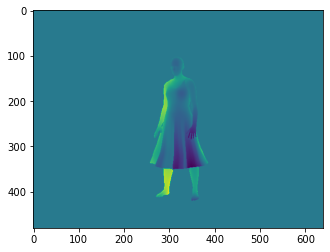

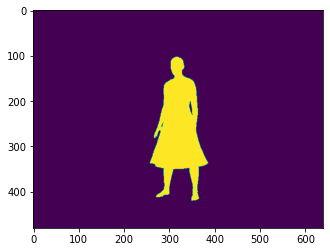

In [6]:
import numpy as np
from util import intrinsic, extrinsic
from depth_render import Render
import matplotlib.pyplot as plt

# Display utils used on this notebook require triangulated faces
def quads2tris(F):
    out = []
    for f in F:
        if len(f) == 3: out += [f]
        elif len(f) == 4: out += [[f[0],f[1],f[2]],
                                [f[0],f[2],f[3]]]
        else: print("This should not happen...")
    return np.array(out, np.int32)

""" Human """
V, F = reader.read_human(sample, frame)
F = np.array(F)

""" Garments """           
garments = list(info['outfit'].keys())
for i,garment in enumerate(garments):
    _V = reader.read_garment_vertices(sample, garment, frame)
    _F = reader.read_garment_topology(sample, garment)
    _F = quads2tris(_F)
    
    # Merge human and garment meshes into one (for visualization purposes)
    F = np.concatenate((F,_F + V.shape[0]),0)
    V = np.concatenate((V,_V),0)
    
    del _V
    del _F
    
max_depth = 10
render = Render(max_depth=max_depth)
render.set_mesh(V, F)
render.set_image(640, 480, intrinsic(), extrinsic(info['camLoc']))
depth = render.render().squeeze()

thresh = max_depth - 1
mask = depth<thresh
dmin = depth.min()
dmean = depth[mask].mean()
dmax = depth[mask].max()
depth[mask] = depth[mask] - dmean
depth[~mask] = 0.0
mask = mask.astype(np.float32)
print('{} {} {}'.format(dmin, dmean, dmax))

plt.imshow(depth)
plt.show()
plt.imshow(mask)
plt.show()

<h2>Mesh color data</h2>

<h3>UV Mapping</h3>

During rendering, color is assigned to meshes through standard texture UV mapping. Explanation of the underlying mechanism of rendering a textured mesh is outside the scope of this notebook.<br>
NOTE: some graphic engines invert UV map vertical coordinate during the transformation to pixel space. Blender's graphic engines work like this. For an example on how UV to pixel mapping is performed, we refer to 'StaterKit/DataReader/util.py', function 'uv_to_pixel', at the end of the file.

<h3>Vertex Color</h3>

Alternatively, meshes can be colored by assigning a color to each vertex. This aproach depends directly on mesh topology and has limited capacity to display texture details. Nevertheless, we believe it is a valid approach and a good entry point for students that are not experts on the topic.

We provide a functionality to gather the colors of each vertex of a given garment.<br>
NOTE: color is gathered at the EXACT vertex location, so it can be understood as a very coarse approximation of the actual mesh color. Expect misbehaviours for some samples.

In [7]:
# Read garment vertices and faces again
garment = garments[0]
V = reader.read_garment_vertices(sample, garment, frame)
F = reader.read_garment_topology(sample, garment)
# Read garment vertex colors
Vt, Ft = reader.read_garment_UVMap(sample, garment) # UV map required to estimate vertex color
C = reader.read_garment_vertex_colors(sample, garment, F, Vt, Ft)
if C.ndim == 1: C = np.stack([C]*V.shape[0], 0) # Plain RGB color
F = quads2tris(F) # Do not triangulate before gathering vertex color (inconsistent UV map)

""" DISPLAY """
fig = go.Figure(data=[
    go.Mesh3d(
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],
        # i, j and k give the vertices of triangles
        i = F[:,0],
        j = F[:,1],
        k = F[:,2],
        vertexcolor = C[:,[2,1,0]],
        showscale = True
    )
])
fig.show()

<h2>RGBA data</h2>

<h6>System dependencies</h6>
<ul>
    <li>ffmpeg</li>
</ul>

In an effort to reduce dataset storage size, we provide RGBA data compressed in videos. Renderings have transparent background to allow students to use any background or none at all. As a compromise between data size and reconstruction quality, we compress RGB channels and Alpha channel in different videos. RGB data is compressed with a CRF (Constant Rate Factor) of 18. CRF 18 is well known for producing a "visually lossless" compression. Alpha is compressed with a lossless algorithm, allowing the EXACT reconstruction of this channel.<br>

We want to highlight the main motivation for video compression. To reduce storage size while preserving data integrity. For this reason, students must expect non-appealing samples (rough edges) when visualizing RGB videos directly without the corresponding Alpha channel.

<h3>Extracting video frames</h3>

To reconstruct the original frames we provide with a script, at 'StarterKit/DataReader/extract_frames.py'.<br>
Calling the script with no args shall extract the frames of all the samples. Optionally the name of a sample can be passed as an arg to extract the frames of this sample alone.<br>
NOTE: students shall change path to data if necessary (line 28).
<h3>Usage</h3>
<br>
<div style="inline:block; color:#555; background-color:#EEE; border:1px solid gray; padding:5px">
    python extract_frames.py<br>
    python extract_frames.py [sample]<br>
</div>
<br>
Again, students might reckon using their own I/O functions according to their needs.

<h2>Visualization</h2>

<h6>Requirements</h6>
<ul>
    <li>Blender</li>
</ul>    


In order to visualize fully textured sequences with their corresponding settings we included a python script for Blender, at 'StarterKit/DataReader/view.py'.

<h3>Usage</h3>
<br>
<div style="inline:block; color:#555; background-color:#EEE; border:1px solid gray; padding:5px">
    blender --python view.py -- [sample]<br>
    blender --python view.py -- [sample] [n.frame]
</div>

For the sake of simplicity and performance speed, this setup uses Blender's rasterizer engine (EEVEE) instead of its ray tracing engine (CYCLES). Also, PBR materials used on the renderings to simulate realistic fabrics are omitted from this visualization tool. Students should expect differences in the way light interacts with objects under this setup w.r.t. to data frames.